<a href="https://colab.research.google.com/github/bttrung/CVND-udacity-facebook-scholarship/blob/master/CVND_Exercise_1_Facial_keypoints_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2019-10-09 16:30:54--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.161.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.161.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.5’

train-test-data.zip 100%[===================>] 322.93M  86.0MB/s    in 3.9s    

2019-10-09 16:30:58 (82.6 MB/s) - ‘/data/train-test-data.zip.5’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [0]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
# from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=7000, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=7000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=73728, out_features=7000, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=7000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])


/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [0]:
# load training data in batches
batch_size = 15

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [0]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)

In [0]:
# load test data in batches
batch_size = 15

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [0]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([15, 1, 224, 224])
torch.Size([15, 68, 2])
torch.Size([15, 68, 2])


In [0]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

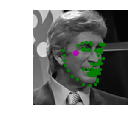

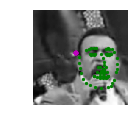

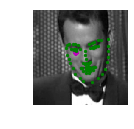

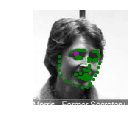

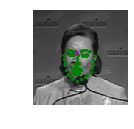

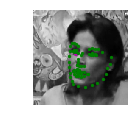

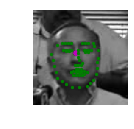

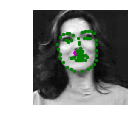

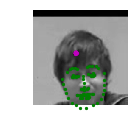

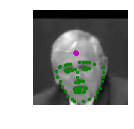

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu())

In [0]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


In [0]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')

In [17]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
# with active_session():
train_net(n_epochs)

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.2856778472661972
Epoch: 1, Batch: 20, Avg. Loss: 0.2666740283370018
Epoch: 1, Batch: 30, Avg. Loss: 0.29382678121328354
Epoch: 1, Batch: 40, Avg. Loss: 0.27692764103412626
Epoch: 1, Batch: 50, Avg. Loss: 0.28260996490716933
Epoch: 1, Batch: 60, Avg. Loss: 0.2976038157939911
Epoch: 1, Batch: 70, Avg. Loss: 0.284365750849247
Epoch: 1, Batch: 80, Avg. Loss: 0.2577288866043091
Epoch: 1, Batch: 90, Avg. Loss: 0.25086677074432373
Epoch: 1, Batch: 100, Avg. Loss: 0.2459646835923195
Epoch: 1, Batch: 110, Avg. Loss: 0.2661134198307991
Epoch: 1, Batch: 120, Avg. Loss: 0.26178702563047407
Epoch: 1, Batch: 130, Avg. Loss: 0.22437017261981965
Epoch: 1, Batch: 140, Avg. Loss: 0.2074712634086609
Epoch: 1, Batch: 150, Avg. Loss: 0.2084548369050026
Epoch: 1, Batch: 160, Avg. Loss: 0.14802807718515396
Epoch: 1, Batch: 170, Avg. Loss: 0.1199094757437706
Epoch: 1, Batch: 180, Avg. Loss: 0.1290655292570591
Epoch: 1, Batch: 190, Avg. Loss: 0.11928436532616615
Epoch: 1, Batc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.09711515605449676
Epoch: 2, Batch: 20, Avg. Loss: 0.12529512569308282
Epoch: 2, Batch: 30, Avg. Loss: 0.12191095724701881
Epoch: 2, Batch: 40, Avg. Loss: 0.11031682938337325
Epoch: 2, Batch: 50, Avg. Loss: 0.10991311818361282
Epoch: 2, Batch: 60, Avg. Loss: 0.1311027377843857
Epoch: 2, Batch: 70, Avg. Loss: 0.10003775134682655
Epoch: 2, Batch: 80, Avg. Loss: 0.11215522512793541
Epoch: 2, Batch: 90, Avg. Loss: 0.10683363303542137
Epoch: 2, Batch: 100, Avg. Loss: 0.1349043145775795
Epoch: 2, Batch: 110, Avg. Loss: 0.10217947885394096
Epoch: 2, Batch: 120, Avg. Loss: 0.11936973184347152
Epoch: 2, Batch: 130, Avg. Loss: 0.12283680140972138
Epoch: 2, Batch: 140, Avg. Loss: 0.11801322773098946
Epoch: 2, Batch: 150, Avg. Loss: 0.12581946030259133
Epoch: 2, Batch: 160, Avg. Loss: 0.12865627259016038
Epoch: 2, Batch: 170, Avg. Loss: 0.10141064822673798
Epoch: 2, Batch: 180, Avg. Loss: 0.11660465747117996
Epoch: 2, Batch: 190, Avg. Loss: 0.11199414879083633
Epoc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.10061909407377242
Epoch: 3, Batch: 20, Avg. Loss: 0.11171032413840294
Epoch: 3, Batch: 30, Avg. Loss: 0.12019776627421379
Epoch: 3, Batch: 40, Avg. Loss: 0.09872784689068795
Epoch: 3, Batch: 50, Avg. Loss: 0.1160515271127224
Epoch: 3, Batch: 60, Avg. Loss: 0.12657129839062692
Epoch: 3, Batch: 70, Avg. Loss: 0.10747218579053879
Epoch: 3, Batch: 80, Avg. Loss: 0.09307614527642727
Epoch: 3, Batch: 90, Avg. Loss: 0.10578517988324165
Epoch: 3, Batch: 100, Avg. Loss: 0.11174623146653176
Epoch: 3, Batch: 110, Avg. Loss: 0.09626125767827035
Epoch: 3, Batch: 120, Avg. Loss: 0.08759983070194721
Epoch: 3, Batch: 130, Avg. Loss: 0.11690713316202164
Epoch: 3, Batch: 140, Avg. Loss: 0.1031132310628891
Epoch: 3, Batch: 150, Avg. Loss: 0.09798450395464897
Epoch: 3, Batch: 160, Avg. Loss: 0.13231736347079276
Epoch: 3, Batch: 170, Avg. Loss: 0.10321866720914841
Epoch: 3, Batch: 180, Avg. Loss: 0.11987178921699523
Epoch: 3, Batch: 190, Avg. Loss: 0.10972407013177872
Epoc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.11075751483440399
Epoch: 4, Batch: 20, Avg. Loss: 0.09605187326669692
Epoch: 4, Batch: 30, Avg. Loss: 0.11842811480164528
Epoch: 4, Batch: 40, Avg. Loss: 0.10597417131066322
Epoch: 4, Batch: 50, Avg. Loss: 0.09198631085455418
Epoch: 4, Batch: 60, Avg. Loss: 0.10240376591682435
Epoch: 4, Batch: 70, Avg. Loss: 0.11100430861115455
Epoch: 4, Batch: 80, Avg. Loss: 0.1213544487953186
Epoch: 4, Batch: 90, Avg. Loss: 0.08943589366972446
Epoch: 4, Batch: 100, Avg. Loss: 0.10549045354127884
Epoch: 4, Batch: 110, Avg. Loss: 0.10911142528057098
Epoch: 4, Batch: 120, Avg. Loss: 0.10441789701581002
Epoch: 4, Batch: 130, Avg. Loss: 0.1246645025908947
Epoch: 4, Batch: 140, Avg. Loss: 0.09501415267586708
Epoch: 4, Batch: 150, Avg. Loss: 0.10984279066324235
Epoch: 4, Batch: 160, Avg. Loss: 0.10072133615612984
Epoch: 4, Batch: 170, Avg. Loss: 0.1069754883646965
Epoch: 4, Batch: 180, Avg. Loss: 0.09635742157697677
Epoch: 4, Batch: 190, Avg. Loss: 0.09212284162640572
Epoch

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.0963517114520073
Epoch: 5, Batch: 20, Avg. Loss: 0.09375219270586968
Epoch: 5, Batch: 30, Avg. Loss: 0.10382534861564637
Epoch: 5, Batch: 40, Avg. Loss: 0.09482553973793983
Epoch: 5, Batch: 50, Avg. Loss: 0.12908728122711183
Epoch: 5, Batch: 60, Avg. Loss: 0.10242724269628525
Epoch: 5, Batch: 70, Avg. Loss: 0.10468219816684723
Epoch: 5, Batch: 80, Avg. Loss: 0.09005416706204414
Epoch: 5, Batch: 90, Avg. Loss: 0.08617122024297715
Epoch: 5, Batch: 100, Avg. Loss: 0.08827553167939187
Epoch: 5, Batch: 110, Avg. Loss: 0.11372428461909294
Epoch: 5, Batch: 120, Avg. Loss: 0.0918274037539959
Epoch: 5, Batch: 130, Avg. Loss: 0.08711606785655021
Epoch: 5, Batch: 140, Avg. Loss: 0.10893133282661438
Epoch: 5, Batch: 150, Avg. Loss: 0.10772328227758407
Epoch: 5, Batch: 160, Avg. Loss: 0.09546308368444442
Epoch: 5, Batch: 170, Avg. Loss: 0.09187034964561462
Epoch: 5, Batch: 180, Avg. Loss: 0.11706866919994355
Epoch: 5, Batch: 190, Avg. Loss: 0.09581337310373783
Epoc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.08216357827186585
Epoch: 6, Batch: 20, Avg. Loss: 0.0893010638654232
Epoch: 6, Batch: 30, Avg. Loss: 0.09832381159067154
Epoch: 6, Batch: 40, Avg. Loss: 0.09233012683689594
Epoch: 6, Batch: 50, Avg. Loss: 0.09085796438157559
Epoch: 6, Batch: 60, Avg. Loss: 0.1057433009147644
Epoch: 6, Batch: 70, Avg. Loss: 0.09804050624370575
Epoch: 6, Batch: 80, Avg. Loss: 0.09677322916686534
Epoch: 6, Batch: 90, Avg. Loss: 0.10629839599132537
Epoch: 6, Batch: 100, Avg. Loss: 0.09620228782296181
Epoch: 6, Batch: 110, Avg. Loss: 0.10042589232325554
Epoch: 6, Batch: 120, Avg. Loss: 0.10076989233493805
Epoch: 6, Batch: 130, Avg. Loss: 0.08840075805783272
Epoch: 6, Batch: 140, Avg. Loss: 0.090404911339283
Epoch: 6, Batch: 150, Avg. Loss: 0.09716941863298416
Epoch: 6, Batch: 160, Avg. Loss: 0.09906441122293472
Epoch: 6, Batch: 170, Avg. Loss: 0.10334544107317925
Epoch: 6, Batch: 180, Avg. Loss: 0.11345975697040558
Epoch: 6, Batch: 190, Avg. Loss: 0.09227029606699944
Epoch:

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.09146154560148716
Epoch: 7, Batch: 20, Avg. Loss: 0.08916396647691727
Epoch: 7, Batch: 30, Avg. Loss: 0.10475439578294754
Epoch: 7, Batch: 40, Avg. Loss: 0.09357805252075195
Epoch: 7, Batch: 50, Avg. Loss: 0.10444528236985207
Epoch: 7, Batch: 60, Avg. Loss: 0.11346480250358582
Epoch: 7, Batch: 70, Avg. Loss: 0.1053163081407547
Epoch: 7, Batch: 80, Avg. Loss: 0.10221366286277771
Epoch: 7, Batch: 90, Avg. Loss: 0.08885869234800339
Epoch: 7, Batch: 100, Avg. Loss: 0.08954251669347287
Epoch: 7, Batch: 110, Avg. Loss: 0.09981032200157643
Epoch: 7, Batch: 120, Avg. Loss: 0.10313897989690304
Epoch: 7, Batch: 130, Avg. Loss: 0.0994824230670929
Epoch: 7, Batch: 140, Avg. Loss: 0.09242857098579407
Epoch: 7, Batch: 150, Avg. Loss: 0.11055513471364975
Epoch: 7, Batch: 160, Avg. Loss: 0.08115734085440636
Epoch: 7, Batch: 170, Avg. Loss: 0.08807282187044621
Epoch: 7, Batch: 180, Avg. Loss: 0.10762749277055264
Epoch: 7, Batch: 190, Avg. Loss: 0.10555801689624786
Epoc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.08840570077300072
Epoch: 8, Batch: 20, Avg. Loss: 0.09622234031558037
Epoch: 8, Batch: 30, Avg. Loss: 0.0985374752432108
Epoch: 8, Batch: 40, Avg. Loss: 0.08367509879171849
Epoch: 8, Batch: 50, Avg. Loss: 0.11323114857077599
Epoch: 8, Batch: 60, Avg. Loss: 0.10509340018033982
Epoch: 8, Batch: 70, Avg. Loss: 0.1084707297384739
Epoch: 8, Batch: 80, Avg. Loss: 0.09641487300395965
Epoch: 8, Batch: 90, Avg. Loss: 0.09555771350860595
Epoch: 8, Batch: 100, Avg. Loss: 0.10469153821468354
Epoch: 8, Batch: 110, Avg. Loss: 0.09401544257998466
Epoch: 8, Batch: 120, Avg. Loss: 0.10176190361380577
Epoch: 8, Batch: 130, Avg. Loss: 0.1250035885721445
Epoch: 8, Batch: 140, Avg. Loss: 0.08959951773285865
Epoch: 8, Batch: 150, Avg. Loss: 0.10812664106488228
Epoch: 8, Batch: 160, Avg. Loss: 0.0984127625823021
Epoch: 8, Batch: 170, Avg. Loss: 0.10034838542342187
Epoch: 8, Batch: 180, Avg. Loss: 0.08035832978785037
Epoch: 8, Batch: 190, Avg. Loss: 0.09805968403816223
Epoch:

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.08044446855783463
Epoch: 9, Batch: 20, Avg. Loss: 0.08521542772650718
Epoch: 9, Batch: 30, Avg. Loss: 0.08920920342206955
Epoch: 9, Batch: 40, Avg. Loss: 0.096025375649333
Epoch: 9, Batch: 50, Avg. Loss: 0.10233540758490563
Epoch: 9, Batch: 60, Avg. Loss: 0.10171577632427216
Epoch: 9, Batch: 70, Avg. Loss: 0.09281555488705635
Epoch: 9, Batch: 80, Avg. Loss: 0.11529361754655838
Epoch: 9, Batch: 90, Avg. Loss: 0.08893044702708722
Epoch: 9, Batch: 100, Avg. Loss: 0.08927085101604462
Epoch: 9, Batch: 110, Avg. Loss: 0.10978731475770473
Epoch: 9, Batch: 120, Avg. Loss: 0.08841149359941483
Epoch: 9, Batch: 130, Avg. Loss: 0.11174964606761932
Epoch: 9, Batch: 140, Avg. Loss: 0.11047491133213043
Epoch: 9, Batch: 150, Avg. Loss: 0.11279930621385574
Epoch: 9, Batch: 160, Avg. Loss: 0.10678136348724365
Epoch: 9, Batch: 170, Avg. Loss: 0.10657506287097931
Epoch: 9, Batch: 180, Avg. Loss: 0.08985232040286065
Epoch: 9, Batch: 190, Avg. Loss: 0.11013196930289268
Epoc

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.09060547724366189
Epoch: 10, Batch: 20, Avg. Loss: 0.08714439608156681
Epoch: 10, Batch: 30, Avg. Loss: 0.10712287425994874
Epoch: 10, Batch: 40, Avg. Loss: 0.09748538136482239
Epoch: 10, Batch: 50, Avg. Loss: 0.09628792405128479
Epoch: 10, Batch: 60, Avg. Loss: 0.14254751652479172
Epoch: 10, Batch: 70, Avg. Loss: 0.09256264828145504
Epoch: 10, Batch: 80, Avg. Loss: 0.0813358560204506
Epoch: 10, Batch: 90, Avg. Loss: 0.07999072931706905
Epoch: 10, Batch: 100, Avg. Loss: 0.11428123638033867
Epoch: 10, Batch: 110, Avg. Loss: 0.09692122116684913
Epoch: 10, Batch: 120, Avg. Loss: 0.09094926118850707
Epoch: 10, Batch: 130, Avg. Loss: 0.1060419999063015
Epoch: 10, Batch: 140, Avg. Loss: 0.09383195340633392
Epoch: 10, Batch: 150, Avg. Loss: 0.08598193526268005
Epoch: 10, Batch: 160, Avg. Loss: 0.09462125301361084
Epoch: 10, Batch: 170, Avg. Loss: 0.09042717143893242
Epoch: 10, Batch: 180, Avg. Loss: 0.09657062590122223
Epoch: 10, Batch: 190, Avg. Loss: 0.098

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/content/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([15, 1, 224, 224])
torch.Size([15, 68, 2])
torch.Size([15, 68, 2])


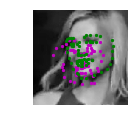

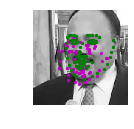

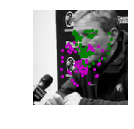

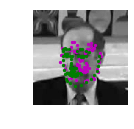

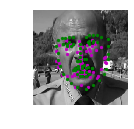

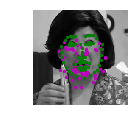

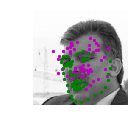

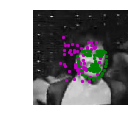

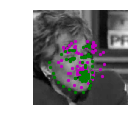

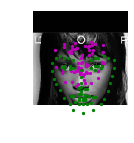

In [19]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images.cpu(), test_outputs.cpu(), gt_pts.cpu())

[[ 0.1118715   0.14934728  0.20021191 -0.12988198 -0.19299713]
 [-0.16382813  0.1830843   0.17059554  0.1108032   0.13524291]
 [-0.16763553  0.1789247  -0.13478549 -0.07748615  0.16175649]
 [-0.04990054  0.12742881 -0.14969768  0.17523211 -0.07966045]
 [-0.1750897   0.04350152 -0.127864    0.03595862  0.02487278]]
(5, 5)


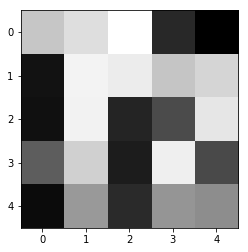

In [21]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data.cpu()

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')